# Using DL

In [1]:
import gc
import os
import random
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, transforms

In [2]:
train_dir = "Images/train/"
image_dir = "Images/"
test_dir = "Images/test/"
artifacts_dir = "Artifacts"

In [3]:
# # Clean
# for file_ in os.listdir(artifacts_dir):
#     if ".pkl" in file_:
#         os.remove(f"{artifacts_dir}/{file_}")

# if "train" in os.listdir(image_dir):
#     shutil.rmtree(train_dir)
#     if "test" in os.listdir(image_dir):
#         shutil.rmtree(test_dir)
# shutil.copytree("../train/", train_dir)
# shutil.copytree("../test/", test_dir)

# ROI

In [3]:
face_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(face_cascade_path)


for class_ in os.listdir(train_dir):
    for img_ in os.listdir(f"{train_dir}/{class_}"):
        img_array = cv2.imread(f"{train_dir}/{class_}/{img_}")
        gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(
            gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)
        )
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            img_array = img_array[y : y + h, x : x + w]
            cv2.imwrite(f"{train_dir}/{class_}/{img_}", img_array)
            if os.path.getsize(f"{train_dir}/{class_}/{img_}") < 12000:
                print(f"{train_dir}/{class_}/{img_}")
                os.remove(f"{train_dir}/{class_}/{img_}")


for class_ in os.listdir(test_dir):
    for img_ in os.listdir(f"{test_dir}/{class_}"):
        img_array = cv2.imread(f"{test_dir}/{class_}/{img_}")
        gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(
            gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)
        )
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            img_array = img_array[y : y + h, x : x + w]
            cv2.imwrite(f"{test_dir}/{class_}/{img_}", img_array)

Images/train//scarlett_johansson/scarlett_johansson22.png
Images/train//mark_ruffalo/mark_ruffalo33.png
Images/train//mark_ruffalo/mark_ruffalo60.png
Images/train//mark_ruffalo/mark_ruffalo35.png


# Preprocessing

## Histogram Eqalization

In [4]:
def heq(path_):
    img = cv2.imread(path_, cv2.IMREAD_COLOR)
    if img.shape[0] < 100:
        os.remove(path_)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # _Convert_to_HSV_colorspace

    # Creating_Mask
    hsv[:, :, 2] = cv2.equalizeHist(hsv[:, :, 2])
    Meq_color = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    cv2.imwrite(path_, Meq_color)


for _ in range(2):
    for class_ in os.listdir(train_dir):
        for img_ in os.listdir(f"{train_dir}/{class_}"):
            heq(path_=f"{train_dir}/{class_}/{img_}")

for _ in range(2):
    for class_ in os.listdir(test_dir):
        for img_ in os.listdir(f"{test_dir}/{class_}"):
            heq(path_=f"{test_dir}/{class_}/{img_}")

## Sample Data

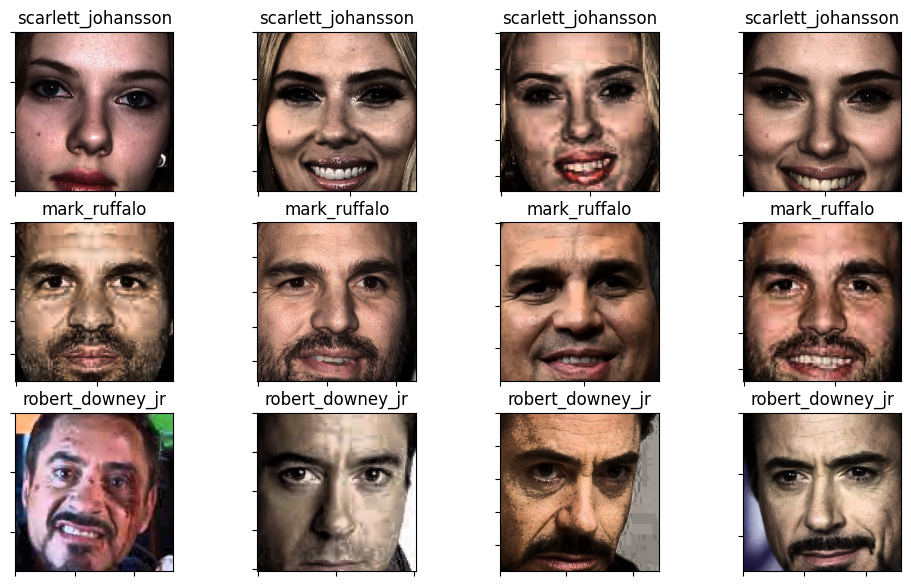

In [5]:
def get_randoms():
    gc.collect()
    img_dirs = os.listdir(train_dir)
    classes_ = sorted(os.listdir(train_dir))
    fig, ax = plt.subplots(len(classes_), 4, figsize=(12, 7))

    j = 0
    for img_dir in img_dirs:
        i = 0
        choices = random.choices(os.listdir(f"{train_dir}/{img_dir}"), k=4)
        for img_ in choices:
            path_ = f"{train_dir}/{img_dir}/{img_}"
            img = cv2.imread(path_)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax[j][i].set_title(f"{img_dir}")
            ax[j][i].imshow(img)
            ax[j][i].set_xticklabels([])
            ax[j][i].set_yticklabels([])
            i += 1
        j += 1


get_randoms()

In [6]:
class preprocessing:
    def __init__(self, class_names=None):
        self.img_dir = train_dir
        self.classes = os.listdir(self.img_dir)
        # Returns a list of all class names in the training image.
        if not class_names:
            class_names = os.listdir(self.img_dir)
        self.class_names = class_names
        self.test_dir = test_dir

    # Class balance
    def class_balance(self):
        class_size = []
        # Add the size of each class in the class_names list.
        for class_name in self.class_names:
            w_dir_ = self.img_dir + class_name + "/"
            class_size.append(len(os.listdir(w_dir_)))
        max_index = class_size.index(max(class_size))
        # Copy all classes in the training directory to the train directory.
        for class_name in self.class_names:
            w_dir_ = self.img_dir + class_name + "/"
            size_ = len(os.listdir(w_dir_))
            differ = class_size[max_index] - size_
            # Copy random choices from the current class size to the current class size.
            if size_ != class_size[max_index]:
                choices = random.choices(os.listdir(w_dir_), k=differ)
                # Copy all the choices in the choices list to the current directory.
                for choice in choices:
                    try:
                        shutil.copy(
                            w_dir_ + choice,
                            w_dir_ + choice.replace("Image", "Image_copy"),
                        )
                    except:
                        break
            size_ = len(os.listdir(w_dir_))
            if size_ != class_size[max_index]:
                self.class_balance()
        self.split_images()

    def split_images(self):
        # Splitting Images into train,test
        try:
            os.mkdir(self.test_dir)
        except:
            pass
        # Move images from the test directory to the test directory.
        for class_ in self.class_names:
            _images = os.listdir(self.img_dir + class_)
            total_images = len(_images)
            choice = random.choices(_images, k=int(total_images * 0.5))  # 40% test
            if class_ not in os.listdir(self.test_dir):
                os.mkdir(self.test_dir + "/" + class_)
            # Move all files in choice to the test directory
            for i in choice:
                try:
                    shutil.move(
                        self.img_dir + class_ + "/" + i,
                        self.test_dir + "/" + class_,
                    )
                except:
                    continue
        # self.augment_()

    def augment_image(self, image, output_dir, prefix):
        resized = image

        # Rotate
        angle = np.random.randint(-15, 15)
        rows, cols, _ = resized.shape
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        rotated = cv2.warpAffine(resized, M, (cols, rows))

        # Flip
        flip_direction = np.random.randint(
            0, 3
        )  # 0 = horizontal flip, 1 = vertical flip, 2 = both flips
        flipped = cv2.flip(rotated, flip_direction - 1)

        # Save augmented image
        output_path = os.path.join(output_dir, f"{prefix}_augmented.jpg")
        cv2.imwrite(output_path, flipped)
        # print(f"Augmented image saved: {output_path}")

    def augment_images_in_directory(self, input_dir, output_dir):
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        # Loop through images in input directory
        for filename in os.listdir(input_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(input_dir, filename)

                # Load image
                image = cv2.imread(image_path)

                # Augment image
                self.augment_image(image, output_dir, os.path.splitext(filename)[0])

    def augment_(self):
        # Specify input and output directories
        w_dir = self.img_dir

        for class_ in os.listdir(w_dir):
            input_directory = f"{w_dir}/{class_}"
            output_directory = f"{w_dir}/{class_}"
            self.augment_images_in_directory(input_directory, output_directory)


# obj = preprocessing()
# obj.class_balance()
# obj.split_images()
# obj.augment_()

# tranformer

In [7]:
tranformer = Compose(
    [
        transforms.Resize([299, 299]),
        transforms.RandomAdjustSharpness(2),
        transforms.ToTensor(),
    ]
)

train_dataset = ImageFolder(train_dir, transform=tranformer)
val_dataset = ImageFolder(test_dir, transform=tranformer)

BATCH_SIZE = len(os.listdir(f"{test_dir}/{os.listdir(test_dir)[0]}"))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

for root, dirs, files in os.walk(train_dir):
    print(f"{root} : {len(files)}")

for root, dirs, files in os.walk(test_dir):
    print(f"{root} : {len(files)}")

Images/train/ : 0
Images/train/scarlett_johansson : 27
Images/train/mark_ruffalo : 26
Images/train/robert_downey_jr : 28
Images/test/ : 0
Images/test/scarlett_johansson : 12
Images/test/mark_ruffalo : 12
Images/test/robert_downey_jr : 12


# Archs

In [8]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x


class Inception_3(nn.Module):
    def __init__(self, num_classes):
        super(Inception_3, self).__init__()
        self.Inception = models.Inception3(
            init_weights=models.Inception_V3_Weights.IMAGENET1K_V1,
            num_classes=num_classes,
        )
        num_features = self.Inception.fc.in_features
        self.Inception.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.Inception(x)
        return x


class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x


class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.vgg16 = models.vgg16(weights=models.vgg.VGG16_Weights.DEFAULT)
        num_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.vgg16(x)
        return x


class VGG19(nn.Module):
    def __init__(self, num_classes):
        super(VGG19, self).__init__()
        self.vgg19 = models.vgg19(weights=models.vgg.VGG19_Weights.DEFAULT)
        num_features = self.vgg19.classifier[6].in_features
        self.vgg19.classifier[6] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.vgg19(x)
        return x

In [9]:
def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    device = (
        "cuda" if torch.cuda.is_available() else "cpu"
    )  # Get the device of the model parameters
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            model = model.to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            total_loss += loss.item() * inputs.size(0)
            total_correct += (predicted == labels).sum().item()
            total_samples += inputs.size(0)

    average_loss = total_loss / total_samples
    accuracy = (total_correct / total_samples) * 100.0

    # print("Test Loss: {:.4f}, Accuracy: {:.2f}%".format(average_loss, accuracy))

    return average_loss, accuracy


def train_and_test(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    device = (
        "cuda" if torch.cuda.is_available() else "cpu"
    )  # Get the device of the model parameters

    test_losses = []
    test_accs = []
    train_acc = []
    train_losses = []
    epoks = []

    for epoch in tqdm.tqdm(range(1, num_epochs + 1)):
        # for epoch in range(1, num_epochs + 1):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:
            model = model.to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Clear the gradients

            try:
                outputs = model(inputs)
            except:
                outputs = model(inputs.squeeze(dim=0))

            try:
                loss = criterion(outputs.logits, labels)
            except:
                loss = criterion(outputs, labels)

            try:
                _, predicted = torch.max(outputs, 1)
            except:
                _, predicted = torch.max(outputs.logits, 1)

            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model parameters

            total_loss += loss.item() * inputs.size(0)
            total_correct += (predicted == labels).sum().item()
            total_samples += inputs.size(0)

        average_loss = total_loss / total_samples
        accuracy = (total_correct / total_samples) * 100.0

        # print(
        #     "Epoch [{}/{}], Train Loss: {:.4f}, Accuracy: {:.2f}%".format(
        #         epoch + 1, num_epochs, average_loss, accuracy
        #     )
        # )

        # Test the model
        test_loss, test_acc = test_model(model, test_loader, criterion)

        if epoch % 5 == 0:
            epoks.append(epoch)
            train_losses.append(average_loss)
            train_acc.append(accuracy)
            test_losses.append(test_loss)
            test_accs.append(test_acc)

    results = {
        "Epoch": epoks,
        "Train Loss": train_losses,
        "Test Loss": test_losses,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_accs,
    }
    return results,test_acc


state_dicts = {}
resultant = {}
n_classes = len(os.listdir(train_dir))
archs = [VGG16, VGG19, ResNet18, ResNet50]
for arch in archs:
    try:
        del model
    except:
        pass
    model = arch(num_classes=n_classes)
    train_loader = train_dataloader
    test_loader = test_loader
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    num_epochs = 50

    # Train and test the model
    torch.cuda.empty_cache()
    gc.collect()
    results, test_acc = train_and_test(
        model, train_loader, test_loader, criterion, optimizer, num_epochs
    )
    if test_acc>85:
        state_dicts[str(arch)] = model
    results = pd.DataFrame(results).set_index("Epoch")
    print(arch)
    print(results)

100%|██████████| 50/50 [03:07<00:00,  3.76s/it]


<class '__main__.VGG16'>
       Train Loss  Test Loss  Train Accuracy  Test Accuracy
Epoch                                                      
5        0.903726   0.885305       70.370370      77.777778
10       0.541477   0.578304       88.888889      86.111111
15       0.264299   0.404159       93.827160      88.888889
20       0.114451   0.248386      100.000000      91.666667
25       0.048684   0.188039      100.000000      94.444444
30       0.025936   0.193666      100.000000      91.666667
35       0.016201   0.164077      100.000000      94.444444
40       0.009602   0.170791      100.000000      94.444444
45       0.009053   0.198293      100.000000      94.444444
50       0.006945   0.201012      100.000000      94.444444


100%|██████████| 50/50 [03:29<00:00,  4.19s/it]


<class '__main__.VGG19'>
       Train Loss  Test Loss  Train Accuracy  Test Accuracy
Epoch                                                      
5        0.932277   0.935036       65.432099      83.333333
10       0.630095   0.671365       83.950617      97.222222
15       0.344032   0.367184       93.827160      94.444444
20       0.144574   0.225552       97.530864      97.222222
25       0.054495   0.176001      100.000000      97.222222
30       0.040381   0.189938      100.000000      94.444444
35       0.043212   0.133886       98.765432      97.222222
40       0.015397   0.146360      100.000000      97.222222
45       0.014656   0.149124      100.000000      97.222222
50       0.010906   0.123285      100.000000      97.222222


100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


<class '__main__.ResNet18'>
       Train Loss  Test Loss  Train Accuracy  Test Accuracy
Epoch                                                      
5        0.907876   0.984954       71.604938      58.333333
10       0.703576   0.781470       96.296296      86.111111
15       0.541304   0.643460       96.296296      94.444444
20       0.424960   0.543220      100.000000      97.222222
25       0.329439   0.464829      100.000000      97.222222
30       0.288670   0.410182      100.000000      97.222222
35       0.203281   0.357240      100.000000      97.222222
40       0.206780   0.321642      100.000000      97.222222
45       0.148899   0.290519      100.000000     100.000000
50       0.132369   0.252530      100.000000     100.000000


100%|██████████| 50/50 [02:08<00:00,  2.57s/it]

<class '__main__.ResNet50'>
       Train Loss  Test Loss  Train Accuracy  Test Accuracy
Epoch                                                      
5        0.983657   0.976284       69.135802      72.222222
10       0.848515   0.854712       87.654321      80.555556
15       0.741367   0.739300       90.123457      91.666667
20       0.601490   0.655249       97.530864      88.888889
25       0.532712   0.565894       98.765432      91.666667
30       0.396501   0.483510       97.530864      88.888889
35       0.363683   0.408326       98.765432      91.666667
40       0.256463   0.354530      100.000000      94.444444
45       0.174835   0.319473      100.000000      94.444444
50       0.243697   0.300054      100.000000      88.888889


# Saving weights and bias of best perfoming model

In [10]:
models = list(state_dicts.keys())

for model in models:
    try:
        model_ = state_dicts[model]
        print(f"{artifacts_dir}/{model}")
        torch.save(
            model_, f"{artifacts_dir}/{model.split('.')[-1].replace('>','')[:-1]}.pt"
        )
    except:
        continue

Artifacts/<class '__main__.VGG16'>
Artifacts/<class '__main__.VGG19'>
Artifacts/<class '__main__.ResNet18'>
Artifacts/<class '__main__.ResNet50'>


## Model Inferencing

ResNet18.pt
ResNet50.pt
VGG16.pt
VGG19.pt


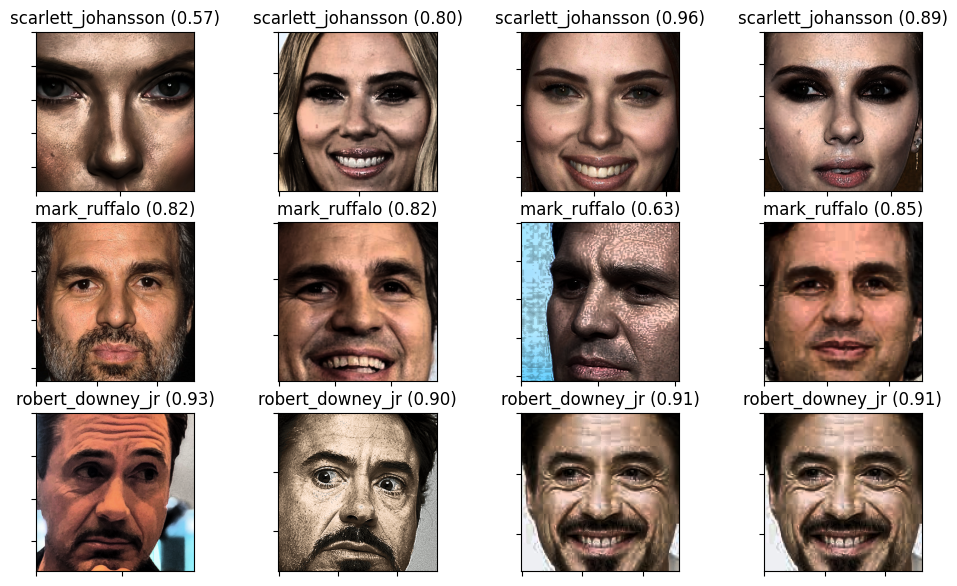

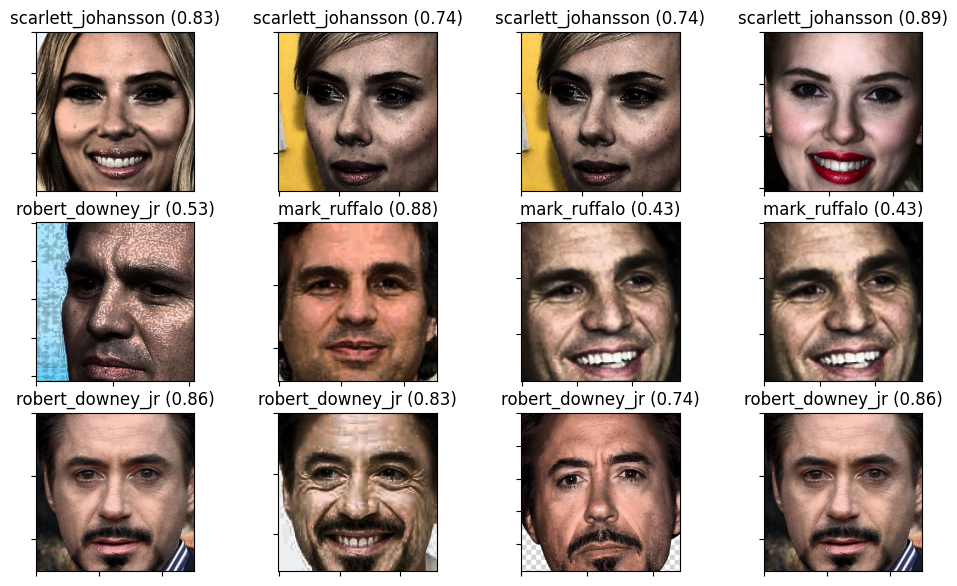

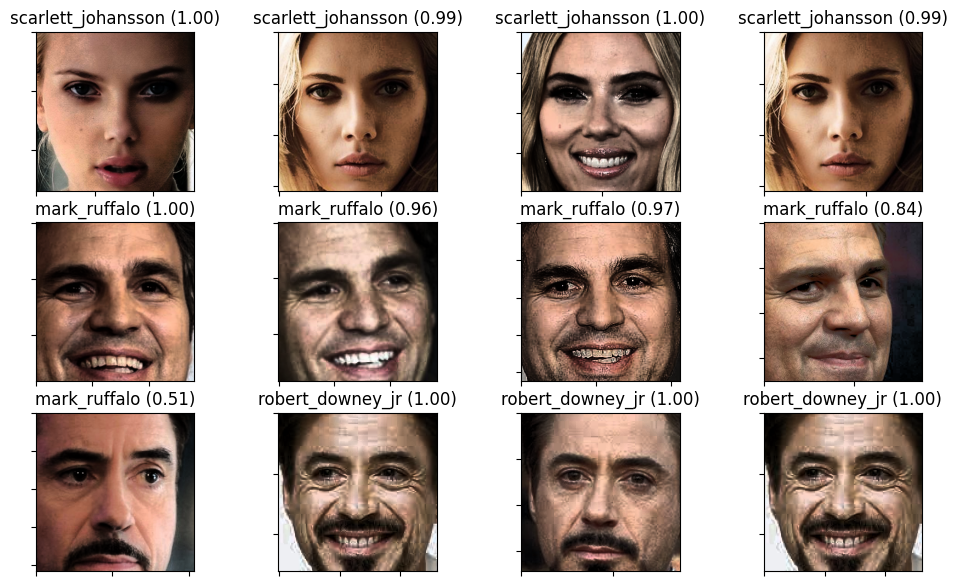

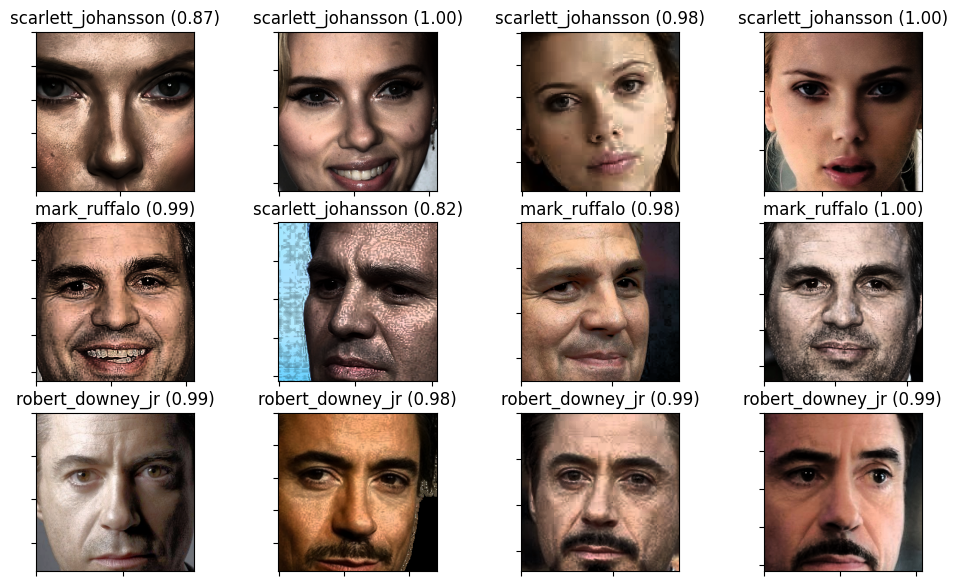

In [15]:
tranformer2 = transforms.Compose(
    [transforms.ToPILImage(), transforms.Resize([299, 299]), transforms.ToTensor()]
)


def predict(img, model):
    img = tranformer2(img)
    res = model((img).unsqueeze(dim=0).to("cuda"))
    return torch.softmax(res, dim=1), torch.argmax(res, dim=1)[0]


def pred_randoms(model, model_name):
    img_dirs = os.listdir(test_dir)
    classes_ = sorted(os.listdir(train_dir))
    fig, ax = plt.subplots(n_classes, 4, figsize=(12, 7))
    j = 0
    for img_dir in img_dirs:
        i = 0
        choices = random.choices(os.listdir(f"{test_dir}/{img_dir}"), k=4)
        for img_ in choices:
            path_ = f"{test_dir}/{img_dir}/{img_}"
            img = cv2.imread(path_)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            _, res = predict(img, model)
            ax[j][i].set_title(
                f"{classes_[res]} ({(max(_.detach().to('cpu')[0])):.2f})"
            )
            ax[j][i].imshow(img)
            ax[j][i].set_xticklabels([])
            ax[j][i].set_yticklabels([])
            i += 1
        j += 1


for model in sorted(os.listdir(artifacts_dir)):
    gc.collect()
    torch.cuda.empty_cache()
    if ".pt" in model:
        print(model)
        model_ = torch.load(f"{artifacts_dir}/{model}").eval()
        pred_randoms(model_, model)